In [24]:
# !pip install mitiq
# !pip install qiskit


In [25]:
# pip install pylatexenc

In [26]:
import numpy as np
from qiskit import *
import qiskit
from qiskit import Aer
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error
import pandas as pd
from qiskit.test.mock import *
import matplotlib.pyplot as plt
from qiskit.providers.aer import AerSimulator
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
import itertools
import mitiq
import argparse
# import cma
import os
import sys
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
import atexit

In [27]:
from qiskit import *
# Qiskit module
from qiskit import QuantumCircuit
import qiskit.circuit.library as circuit_library
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit

# Qiskit tools for running and monitoring jobs
from qiskit import execute
from qiskit.tools.monitor import job_monitor

from qiskit.tools.visualization import *
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.special import erf
# Other imports
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
# Qiskit for pulse 
from qiskit import pulse

from qiskit import *
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform, ShiftPhase
from qiskit.pulse.library import drag, GaussianSquare, Drag
from qiskit.visualization import SchedStyle
from qiskit.providers.aer import AerSimulator

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

from qiskit.circuit.gate import Gate
from mitiq import zne 

In [28]:
mitiq.about()


Mitiq: A Python toolkit for implementing error mitigation on quantum computers
Authored by: Mitiq team, 2020 & later (https://github.com/unitaryfund/mitiq)

Mitiq Version:	0.8.0

Core Dependencies
-----------------
Cirq Version:	0.10.0
NumPy Version:	1.20.3
SciPy Version:	1.4.1

Optional Dependencies
---------------------
PyQuil Version:	Not installed
Qiskit Version:	0.26.0

Python Version:	3.7.6
Platform Info:	Windows (AMD64)


In [29]:
def cx_pulse_instructions(qc: int, qt: int):
    """Retrieve the CNOT pulse schedule for the given
    qubit pair from the backend defaults.
    
    Args:
      qc: control qubit index
      qt: target qubit index
    """
    if [qc, qt] not in backend_config.coupling_map:
        print('Qubit pair has no direct cross resonance!')
    else:
        cx = inst_sched_map.get('cx', qubits=[qc, qt])
        return cx

def Extract_GaussianSquare(q1, q2):
    """Retrieve the Gaussiacross resonance pulse waveform
    for the qubit pair from the cx (CNOT) schedule.
    
    Args:
      q1: control qubit index
      q2: target qubit index
    """
    cx = cx_pulse_instructions(q1, q2)
    cx1 = cx_pulse_instructions(q2, q1)
       
    if cx.instructions[-1][0] < cx1.instructions[-1][0]: # get longer cnot gate pulse schedule 
        cx=cx1
    idx = 0
    Dr_gs = [] # get the gaussiansquare pulse of drive channel
    cr_gs = [] # get the gaussiansquare pulse of control channel
    control_channel='' # get the corresponding control channel for q1 and q2
    Drive_Channel=''    # get the corresponding drive channel with gaussiansquare pulse
    another_Drive_Channel='' # get another drive channel
    
    #look for them
    
    N = 1
    for i in range(len(cx.instructions)):
        if type(cx.instructions[i][1]) is ShiftPhase and type(cx.instructions[i][1].channel) is DriveChannel\
        and cx.instructions[i][1].phase == -math.pi/2 and N == 1 :
            
            another_Drive_Channel=cx.instructions[i][1].channels[0]
            
        if type(cx.instructions[i][1].channels[0]) is ControlChannel and type(cx.instructions[i][1]) is Play\
          and type(cx.instructions[i][1].pulse) is GaussianSquare:

            cr_gs.append(cx.instructions[i][1].pulse)

            control_channel=cx.instructions[i][1].channels[0]

        if type(cx.instructions[i][1].channels[0]) is DriveChannel and type(cx.instructions[i][1]) is Play \
          and type(cx.instructions[i][1].pulse) is GaussianSquare:

            Dr_gs.append(cx.instructions[i][1].pulse)

            Drive_Channel=cx.instructions[i][1].channels[0]
        if type(cx.instructions[i][1]) is Play:
            N=0

    return control_channel, cr_gs, Drive_Channel, Dr_gs, another_Drive_Channel


def Get_Shift_phase_CRTL_Chan(q1, q2): # When driving channel is phase shifted, the corresponding control channel need to be phase shifted. 
    """Get the driving channels' corresponding control channels
    
    Args:
      q1: qubit
      q2: qubit
    out_put: 
      control_chan1: the corresponding control channel of driving channel with 
    """
    cx1 = cx_pulse_instructions(q1, q2)
    cx2 = cx_pulse_instructions(q2, q1)
    if cx1.instructions[-1][0] > cx2.instructions[-1][0]:
        cx1, cx2 = cx2, cx1
    control_chan0 = []
    control_chan1 = []
    for i in range(len(cx2.instructions)):
        if type(cx2.instructions[i][1]) is ShiftPhase and type(cx2.instructions[i][1].channel) is ControlChannel\
        and cx2.instructions[i][1].phase == -math.pi/2 :
            control_chan0.append(cx2.instructions[i][1].channel)
        if type(cx2.instructions[i][1]) is ShiftPhase and type(cx2.instructions[i][1].channel) is ControlChannel\
        and cx2.instructions[i][1].phase == -math.pi :
            control_chan1.append(cx2.instructions[i][1].channel)
        if type(cx2.instructions[i][1]) is Play:
            break

    return control_chan0, control_chan1 


def Rzz_90_gate_schedule (q0,q1):
    uchan, cr_pulse, Dchan, dr_pulse, another_Dchan = Extract_GaussianSquare(q0, q1)
    #Y_chan, X_chan = Get_XY_chan(q0,q1)
    control_chan0, control_chan1 = Get_Shift_phase_CRTL_Chan(q0, q1)
    
    
    Y_q = Dchan.index # corresponding 
    
    X_q = another_Dchan.index
    
    Y90p = inst_sched_map.get('u2', P0=0, P1=0, qubits=[Y_q]).instructions
    
    X_180 = inst_sched_map.get('x', qubits=[X_q]).instructions[0][1].pulse
    
    for Y in Y90p:
        if type(Y[1]) is Play:
            Y_pulse = Y[1].pulse
            
    drive_samples = Y_pulse.duration
    
    cr_samples = cr_pulse[0].duration
  
    Rzz_90_schedule = pulse.Schedule(name="RZZ gate m90 pulse") 
    
    Rzz_90_schedule |= ShiftPhase(-math.pi, Dchan) #<< int(2*cr_samples+2*drive_samples)
    
    for chan in control_chan1:
        Rzz_90_schedule |= ShiftPhase(-math.pi, chan) #<< int(2*cr_samples+2*drive_samples)
    
    Rzz_90_schedule |= Play(Y_pulse, Dchan)
    
    Rzz_90_schedule |= ShiftPhase(-math.pi, Dchan) << int(drive_samples)
    
    for chan in control_chan1: 
        Rzz_90_schedule |= ShiftPhase(-math.pi, chan) << int(drive_samples)

    
    Rzz_90_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
    Rzz_90_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
    Rzz_90_schedule |= Play(X_180, another_Dchan) << int(cr_samples+drive_samples)

    Rzz_90_schedule |= Play(dr_pulse[1], Dchan) << int(cr_samples+2*drive_samples)
    Rzz_90_schedule |= Play(cr_pulse[1], uchan) << int(cr_samples+2*drive_samples)
    
    Rzz_90_schedule |= Play(X_180, another_Dchan) << int(2*cr_samples+2*drive_samples)

    Rzz_90_schedule |= Play(Y_pulse, Dchan) << int(2*cr_samples+2*drive_samples)
    
    return Rzz_90_schedule

def Rzz_gate_schedule (q0,q1,theta):
    
    uchan, cr_pulse, Dchan, dr_pulse, another_Dchan = Extract_GaussianSquare(q0, q1)
    #Y_chan, X_chan = Get_XY_chan(q0,q1)
    control_chan0, control_chan1 = Get_Shift_phase_CRTL_Chan(q0, q1)
    
    Frac = 2*np.abs(theta)/math.pi
    
    Y_q = Dchan.index
    
    X_q = another_Dchan.index
    
    Y90p = inst_sched_map.get('u2', P0=0, P1=0, qubits=[Y_q]).instructions
    
    X_180 = inst_sched_map.get('x', qubits=[X_q]).instructions[0][1].pulse
    
    ### find out Y_90 pulse 
    
    for Y in Y90p:
        
        if type(Y[1]) is Play:
            
            Y_pulse = Y[1].pulse
            
    ###
            
    drive_samples = Y_pulse.duration # The duration of Y pulse
    
    cr_samples = cr_pulse[0].duration # The duration gaussiansquare pulse
    
    cr_width= cr_pulse[0].width # gaussiansquare pulse's width
    
    cr_sigma = cr_pulse[0].sigma # gaussiansquare pulse's standard error
    
    cr_amp = np.abs(cr_pulse[0].amp)
    
    number_std = (cr_samples-cr_width)/cr_sigma
    
    #Area_g = cr_amp*cr_sigma*np.sqrt(2*np.pi)*erf(number_std) # paper
    
    Area_g = cr_amp*cr_sigma*np.sqrt(2*np.pi)*erf(number_std/2/np.sqrt(2)) #modified
    
    Area_pi_2 = cr_width*cr_amp+Area_g 
    
    dr_sigma = dr_pulse[0].sigma
    
    dr_amp = np.abs(dr_pulse[0].amp)
    
    Area_theta = Frac * Area_pi_2
    
    if Area_theta > Area_g:
        
        New_width = (Area_theta-Area_g)/cr_amp
        
        new_duration = math.ceil((New_width+number_std*cr_sigma)/16)*16
        
        New_width = new_duration-number_std*cr_sigma
        
        cr_pulse[0] = GaussianSquare(duration=new_duration, amp=cr_pulse[0].amp, sigma=cr_sigma, width=New_width)
        
        cr_pulse[1] = GaussianSquare(duration=new_duration, amp=-cr_pulse[0].amp, sigma=cr_sigma, width=New_width)
        
        dr_pulse[0] = GaussianSquare(duration=new_duration, amp=dr_pulse[0].amp, sigma=dr_sigma, width=New_width)
        
        dr_pulse[1] = GaussianSquare(duration=new_duration, amp=-dr_pulse[0].amp, sigma=dr_sigma, width=New_width)
        
        
    else:
        
        New_amp_cr =  cr_pulse[0].amp*Area_theta/Area_g
        
        New_amp_dr= dr_pulse[0].amp*Area_theta/Area_g
        
        new_duration = number_std * cr_sigma
        
        cr_pulse[0] = GaussianSquare(duration=new_duration, amp=cr_amp, sigma=cr_sigma, width=0)
        
        cr_pulse[1] = GaussianSquare(duration=new_duration, amp=-cr_amp, sigma=cr_sigma, width=0)
        
        dr_pulse[0] = GaussianSquare(duration=new_duration, amp=dr_amp, sigma=dr_sigma, width=0)
        
        dr_pulse[1] = GaussianSquare(duration=new_duration, amp=-dr_amp, sigma=dr_sigma, width=0)
        
    # Set up the Rzz schedule
    if theta < 0 :
  
        RZZ_schedule = pulse.Schedule(name="RZZ gate pulse") 
    
        ### Y_-90 pulse
    
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) 
    
        for chan in control_chan1:
            
            RZZ_schedule |= ShiftPhase(-math.pi, chan) 
    
        RZZ_schedule |= Play(Y_pulse, Dchan)
    
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(drive_samples)
    
        for chan in control_chan1: 
        
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(drive_samples)
        
         ### 
    
         ### Cross resonant pulses and X rotation echo pulse
    
        RZZ_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
        RZZ_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(new_duration+drive_samples)

        RZZ_schedule |= Play(dr_pulse[1], Dchan) << int(new_duration+2*drive_samples)
        RZZ_schedule |= Play(cr_pulse[1], uchan) << int(new_duration+2*drive_samples)
    
         ###
    
         ### X_180 pulse
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(2*new_duration+2*drive_samples)
    
         ## Y_90 pulse

        RZZ_schedule |= Play(Y_pulse, Dchan) << int(2*new_duration+2*drive_samples)
    
        return RZZ_schedule
    
    else:
        
        RZZ_schedule = pulse.Schedule(name="RZZ gate pulse") 
    
        ### Y_90 pulse
    
    
        RZZ_schedule |= Play(Y_pulse, Dchan)
    
        
         ### 
    
         ### Cross resonant pulses and X rotation echo pulse
    
        RZZ_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
        RZZ_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(new_duration+drive_samples)

        RZZ_schedule |= Play(dr_pulse[1], Dchan) << int(new_duration+2*drive_samples)
        RZZ_schedule |= Play(cr_pulse[1], uchan) << int(new_duration+2*drive_samples)
    
         ###
    
         ### X_180 pulse
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(2*new_duration+2*drive_samples)
    
         ## Y_-90 pulse
        
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(2*new_duration+2*drive_samples)
        
        for chan in control_chan1:
            
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(2*new_duration+2*drive_samples)
        
        RZZ_schedule |= Play(Y_pulse, Dchan) << int(2*new_duration+2*drive_samples)
        
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(2*new_duration+3*drive_samples)
    
        for chan in control_chan1: 
        
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(2*new_duration+3*drive_samples)
    
        return RZZ_schedule

In [30]:
IBMQ.save_account('26595118309e0ea848015d3f7458b040ec723a9c11afd2d777038533a5a2b8079312af1e3713e370053f85bf7dd5d77f72993b0f04c2cd561e4c31f5a40c910c',overwrite=True )
IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-07-29 10:52:46,794: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [31]:
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='iowa-state-uni-1', project='main')

In [32]:
for backend in provider.backends():
    print(backend)

ibmq_qasm_simulator
ibmqx2
ibmq_armonk
ibmq_santiago
ibmq_bogota
ibmq_casablanca
ibmq_lima
ibmq_belem
ibmq_quito
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer
ibmq_jakarta
ibmq_manila
ibm_lagos


In [33]:
backend = provider.get_backend('ibm_lagos')

# from qiskit.test.mock import FakeVigo

# backend = FakeVigo()

properties = backend.properties()

In [34]:
backend_config = backend.configuration()
ham_params = backend_config.hamiltonian['vars']
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")

Sampling time: 0.2222222222222222 ns


In [35]:
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map 
inst_sched_map.instructions

['cx', 'id', 'measure', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']

In [36]:
def post_selection(bit_str):
    """This function takes in a bitstring, and will return False iff 
    there is a 1 next to another 1 in the given bitstring.
    This does NOT consider a bitstring with 1s on either end as next to one another,
    i.e. given a string of the form '10...01', this function should return False"""
    new_str = '0' + bit_str[0:len(bit_str)]
    for i in range(0,len(bit_str)+1):
        if (new_str[i] == '1') & (new_str[i] == new_str[i-1]):
            return False
    return True

def post_selected_expval(counts, qubit):
    """This function takes in the counts from a circuit execution, as well as a qubit index, 
    and outputs <Z> for that qubit after post-selection"""
    copy_counts = counts.copy()
    
    total = []

    for x in counts.keys():
        if not post_selection(x):
            copy_counts.pop(x)

    for x in copy_counts:
        total.append(copy_counts[x])

    total = sum(total)

    one_counts = 0

    for x in copy_counts.keys():
        if x[qubit] == '1':
            one_counts += copy_counts[x]

    prob = one_counts / total

    expval = 2*prob - 1
    
    return expval

In [37]:
def SwapTestExecutor(circuits, backend, shots, post_sel_func, qubit):
    scale_factors = [1.0, 2.0, 3.0]

    folded_circuits = []

    for circuit in circuits:
        folded_circuits.append([zne.scaling.fold_gates_at_random(circuit, scale) for scale in scale_factors])
    folded_circuits = list(itertools.chain(*folded_circuits))

    job = qiskit.execute(
        experiments=folded_circuits,
        backend=backend,
        optimization_level=0,
        shots=shots
    )

    results = job.result()
    mit_results = meas_filter.apply(results)

    expectation_values = []

    for t in range(len(folded_circuits)):
        expectation_values.append(post_selected_expval(mit_results.get_counts(t),qubit))

    zero_noise_values = []
    if isinstance(backend, qiskit.providers.aer.backends.qasm_simulator.QasmSimulator): # exact_sim
        for i in range(len(circuits)):
            zero_noise_values.append(np.mean(expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))
    else: #device_sim
        fac = mitiq.zne.inference.LinearFactory(scale_factors)
        for i in range(len(circuits)):
            zero_noise_values.append(fac.extrapolate(scale_factors, 
            expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))

    return zero_noise_values

# Folding Circuit

In [38]:
#Define the functions used to build the Trotter circuit.
def h_Z(qc,h,dt,qubits_list):
    j=0
    for i in qubits_list:
        if j==0 or j==4:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)
        j+=1
        
def X_Rabi(qc,Omega,dt,qubits_list): # Rabi coupling
    
    for i in qubits_list:
        
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt,qubits_list): # nearest neighbor coupling

    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    qc.rzz(-2*V*dt,q1,q2)
    
    qc.rzz(-2*V*dt,q3,q4)
    
    qc.rzz(-2*V*dt,q0,q1)
    
    qc.rzz(-2*V*dt,q2,q3)

def ZZ_inverse(qc,V,dt,qubits_list): # nearest neighbor coupling

    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    qc.rzz(-2*V*dt,q0,q1)
    
    qc.rzz(-2*V*dt,q2,q3)

    qc.rzz(-2*V*dt,q1,q2)
    
    qc.rzz(-2*V*dt,q3,q4)
    
def ZZ_half(qc,V,dt,qubits_list): # nearest neighbor coupling

    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    qc.rzz(-2*V*dt,q0,q1)
    
    qc.rzz(-2*V*dt,q2,q3)

def Trotter_circuit_5_site_folding_scale1(h,Omega,V,T,n,qubits_list):
    
    t1,t2=DD_T(h,Omega,V,T,n,qubits_list)

    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(backend_config.n_qubits,5)
        
        ### Initial state setting
        
        Trotter_circuit.x(q1)
        
        Trotter_circuit.x(q3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):

            Trotter_circuit.x(q0)
            
            Trotter_circuit.delay(int(t1),q0,'dt')

            Trotter_circuit.z(q0)
            
            Trotter_circuit.x(q0)

            Trotter_circuit.z(q0)

            Trotter_circuit.delay(int(2*t1),q0,'dt')
            
            X_Rabi(Trotter_circuit,Omega,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt,qubits_list) # Z field 

            ZZ(Trotter_circuit,V,dt,qubits_list) 

            # Nearest neighbor hopping term

            Trotter_circuit.x(q4)
            
            Trotter_circuit.delay(int(2*t2),q4,'dt')

            Trotter_circuit.z(q4)
            
            Trotter_circuit.x(q4)

            Trotter_circuit.z(q4)
            
            Trotter_circuit.delay(int(t2),q4,'dt')
            
            Trotter_circuit.barrier()
            
        j=0
        
        for i in qubits_list:
            
            Trotter_circuit.measure(i,j)
            
            j+=1

        Trotter_circuit.add_calibration('rzz', [q0,q1], Rzz_gate_schedule (q0,q1,-2*V*dt), [-2*V*dt]) 
        
        Trotter_circuit.add_calibration('rzz', [q2,q3], Rzz_gate_schedule (q2,q3,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q1,q2], Rzz_gate_schedule (q1,q2,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q3,q4], Rzz_gate_schedule (q3,q4,-2*V*dt), [-2*V*dt])

        Trotter_circuit = transpile(Trotter_circuit, backend)
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

def Trotter_circuit_5_site_folding_scale2(h,Omega,V,T,n,qubits_list):

    t1,t2=DD_T(h,Omega,V,T,n,qubits_list)

    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(backend_config.n_qubits,5)
        
        ### Initial state setting
        
        Trotter_circuit.x(q1)
        
        Trotter_circuit.x(q3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            
            X_Rabi(Trotter_circuit,Omega,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
            Trotter_circuit.barrier()
            
            X_Rabi(Trotter_circuit,-Omega,dt,qubits_list)
            
            X_Rabi(Trotter_circuit,Omega,dt,qubits_list)
            
            h_Z(Trotter_circuit,h,dt,qubits_list) # Z field 

            Trotter_circuit.x(q0)
            
            Trotter_circuit.delay(int(2*t1),q0,'dt')

            Trotter_circuit.z(q0)
            
            Trotter_circuit.x(q0)

            Trotter_circuit.z(q0)
            
            Trotter_circuit.delay(int(t1),q0,'dt')
            
            ZZ(Trotter_circuit,V,dt,qubits_list) # Nearest neighbor hopping term

            Trotter_circuit.x(q4)

            Trotter_circuit.delay(100,q4,'dt')
            
            Trotter_circuit.barrier()
            
            ZZ_half(Trotter_circuit,-V,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
            Trotter_circuit.barrier() # Z field 
            
            ZZ_half(Trotter_circuit,V,dt,qubits_list)
            
            Trotter_circuit.z(q4)
            
            Trotter_circuit.x(q4)

            Trotter_circuit.z(q4)

            Trotter_circuit.delay(100,q4,'dt')
            # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        j=0
        
        for i in qubits_list:
            
            Trotter_circuit.measure(i,j)
            
            j+=1

        Trotter_circuit.add_calibration('rzz', [q0,q1], Rzz_gate_schedule (q0,q1,-2*V*dt), [-2*V*dt]) 
        
        Trotter_circuit.add_calibration('rzz', [q2,q3], Rzz_gate_schedule (q2,q3,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q1,q2], Rzz_gate_schedule (q1,q2,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q3,q4], Rzz_gate_schedule (q3,q4,-2*V*dt), [-2*V*dt])

        Trotter_circuit.add_calibration('rzz', [q1,q2], Rzz_gate_schedule (q1,q2,2*V*dt), [2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q3,q4], Rzz_gate_schedule (q3,q4,2*V*dt), [2*V*dt])

        Trotter_circuit.add_calibration('rzz', [q0,q1], Rzz_gate_schedule (q0,q1,2*V*dt), [2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q2,q3], Rzz_gate_schedule (q2,q3,2*V*dt), [2*V*dt])

        Trotter_circuit = transpile(Trotter_circuit, backend)
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits
    
def Trotter_circuit_5_site_folding_scale3(h,Omega,V,T,n,qubits_list):

    t1,t2=DD_T(h,Omega,V,T,n,qubits_list)

    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(backend_config.n_qubits,5)
        
        ### Initial state setting
        
        Trotter_circuit.x(q1)
        
        Trotter_circuit.x(q3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            
            Trotter_circuit.x(q0)
            
            Trotter_circuit.delay(int(2*t1),q0,'dt')

            Trotter_circuit.z(q0)
            
            Trotter_circuit.x(q0)

            Trotter_circuit.z(q0)
            
            Trotter_circuit.delay(int(t1),q0,'dt')
            
            X_Rabi(Trotter_circuit,Omega,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt,qubits_list) # Z field 
            
            ZZ(Trotter_circuit,V,dt,qubits_list) # Nearest neighbor hopping term

            Trotter_circuit.x(q4)
            
            Trotter_circuit.delay(int(2*t2),q4,'dt')

            Trotter_circuit.z(q4)
            
            Trotter_circuit.x(q4)

            Trotter_circuit.z(q4)
            
            Trotter_circuit.delay(int(t2),q4,'dt')
            
            Trotter_circuit.barrier()
            
            ZZ_inverse(Trotter_circuit,-V,dt,qubits_list) # Nearest neighbor hopping term
            
            h_Z(Trotter_circuit,-h,dt,qubits_list)
            
            X_Rabi(Trotter_circuit,-Omega,dt,qubits_list)
            
            Trotter_circuit.barrier()

            Trotter_circuit.x(q0)
            
            Trotter_circuit.delay(int(2*t1),q0,'dt')

            Trotter_circuit.z(q0)
            
            Trotter_circuit.x(q0)

            Trotter_circuit.z(q0)
            
            Trotter_circuit.delay(int(t1),q0,'dt')
            
            X_Rabi(Trotter_circuit,Omega,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt,qubits_list) # Z field 
            
            ZZ(Trotter_circuit,V,dt,qubits_list) # Nearest neighbor hopping term

            Trotter_circuit.x(q4)
            
            Trotter_circuit.delay(int(2*t2),q4,'dt')

            Trotter_circuit.z(q4)
            
            Trotter_circuit.x(q4)

            Trotter_circuit.z(q4)
            
            Trotter_circuit.delay(int(t2),q4,'dt')
            
            Trotter_circuit.barrier()
            
        j=0
        
        for i in qubits_list:
            
            Trotter_circuit.measure(i,j)
            
            j+=1

        Trotter_circuit.add_calibration('rzz', [q0,q1], Rzz_gate_schedule (q0,q1,-2*V*dt), [-2*V*dt]) 
        
        Trotter_circuit.add_calibration('rzz', [q2,q3], Rzz_gate_schedule (q2,q3,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q1,q2], Rzz_gate_schedule (q1,q2,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q3,q4], Rzz_gate_schedule (q3,q4,-2*V*dt), [-2*V*dt])

        Trotter_circuit.add_calibration('rzz', [q0,q1], Rzz_gate_schedule (q0,q1,2*V*dt), [2*V*dt]) 
        
        Trotter_circuit.add_calibration('rzz', [q2,q3], Rzz_gate_schedule (q2,q3,2*V*dt), [2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q1,q2], Rzz_gate_schedule (q1,q2,2*V*dt), [2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q3,q4], Rzz_gate_schedule (q3,q4,2*V*dt), [2*V*dt])

        Trotter_circuit = transpile(Trotter_circuit, backend)
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

In [39]:
def Trotter_circuit_5_site_wo_m_one_step(h,Omega,V,T,n,qubits_list):
    
    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    Trotter_circuits = []
    
    dt=T/n
        
    Trotter_circuit = QuantumCircuit(backend_config.n_qubits,5)
        
    X_Rabi(Trotter_circuit,Omega,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
    h_Z(Trotter_circuit,h,dt,qubits_list) # Z field 
            
    ZZ(Trotter_circuit,V,dt,qubits_list) # Nearest neighbor hopping term
            
    # add the custom pulse gate into circuit
            
    Trotter_circuit.add_calibration('rzz', [q1,q2], Rzz_gate_schedule (q1,q2,-2*V*dt), [-2*V*dt]) 
        
    Trotter_circuit.add_calibration('rzz', [q3,q4], Rzz_gate_schedule (q3,q4,-2*V*dt), [-2*V*dt])
        
    Trotter_circuit.add_calibration('rzz', [q0,q1], Rzz_gate_schedule (q0,q1,-2*V*dt), [-2*V*dt])
        
    Trotter_circuit.add_calibration('rzz', [q2,q3], Rzz_gate_schedule (q2,q3,-2*V*dt), [-2*V*dt])
        
        
        
    Trotter_circuit = transpile(Trotter_circuit, backend) # compile into specific backend
        
    
        
    return Trotter_circuit

In [40]:
def DD_T(h,Omega,V,T,n,qubits_list):
    
    Trotter_circuit=Trotter_circuit_5_site_wo_m_one_step(h,Omega,V,T,n,qubits_list)
    
    pulse_schedule = schedule(Trotter_circuit, backend)
    
    n0=1
    
    for i in range(len(pulse_schedule.instructions)):
        
        if pulse_schedule.instructions[i][1].channel.index==qubits_list[0]\
        and type(pulse_schedule.instructions[i][1].channels[0]) is not ControlChannel and n0==1:
            
            T_q1 = pulse_schedule.instructions[i][0]
            
            n0=0
            
        if pulse_schedule.instructions[i][1].channel.index==qubits_list[4]:
            
            T_q2 = pulse_schedule.instructions[i][0]
            
            
    T_q2=(pulse_schedule.duration-T_q2-480)/4
        
    T_q1=(T_q1-320)/4
    
    
    return T_q1, T_q2

# Custom gate

In [41]:
def Trotter_circuit_5_site(h,Omega,V,T,n,qubits_list):
    
    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(backend_config.n_qubits,5)
        
        ### Initial state setting
        
        
        Trotter_circuit.x(q1)
        
        Trotter_circuit.x(q3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            
            X_Rabi(Trotter_circuit,Omega,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt,qubits_list) # Z field 
            
            #Trotter_circuit.barrier()
            
            ZZ(Trotter_circuit,V,dt,qubits_list) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        # add the custom pulse gate into circuit
            
        Trotter_circuit.add_calibration('rzz', [q1,q2], Rzz_gate_schedule (q1,q2,-2*V*dt), [-2*V*dt]) 
        
        Trotter_circuit.add_calibration('rzz', [q3,q4], Rzz_gate_schedule (q3,q4,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q0,q1], Rzz_gate_schedule (q0,q1,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q2,q3], Rzz_gate_schedule (q2,q3,-2*V*dt), [-2*V*dt])
        
        j=0
        
        for i in qubits_list:
            
            Trotter_circuit.measure(i,j)
            
            j+=1
        
        Trotter_circuit = transpile(Trotter_circuit, backend) # compile into specific backend
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

# Two CNOT gate

In [42]:
def Trotter_circuit_5_site_no_custom(h,Omega,V,T,n,qubits_list):
    
    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(backend_config.n_qubits,5)
        
        ### Initial state setting
        
        
        Trotter_circuit.x(q1)
        
        Trotter_circuit.x(q3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            
            X_Rabi(Trotter_circuit,Omega,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt,qubits_list) # Z field 
            
            #Trotter_circuit.barrier()
            
            ZZ(Trotter_circuit,V,dt,qubits_list) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
        
        j=0
        
        for i in qubits_list:
            
            Trotter_circuit.measure(i,j)
            
            j+=1
        
        Trotter_circuit = transpile(Trotter_circuit, backend) # compile into specific backend
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

# Dynamical Decoupling

In [43]:
def Trotter_circuit_5_site_DD(h,Omega,V,T,n,qubits_list):
    
    t1,t2=DD_T(h,Omega,V,T,n,qubits_list)
    
    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(backend_config.n_qubits,5)
        
        ### Initial state setting
        
        
        Trotter_circuit.x(q1)
        
        Trotter_circuit.x(q3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            
            Trotter_circuit.y(q0)
            
            Trotter_circuit.delay(int(2*t1),q0,'dt')

            Trotter_circuit.z(q0)
            
            Trotter_circuit.y(q0)

            Trotter_circuit.z(q0)
            
            Trotter_circuit.delay(int(t1),q0,'dt')
            
            X_Rabi(Trotter_circuit,Omega,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt,qubits_list) # Z field 
            
            #Trotter_circuit.barrier()
            
            ZZ(Trotter_circuit,V,dt,qubits_list) # Nearest neighbor hopping term
            
            Trotter_circuit.y(q4)
            
            Trotter_circuit.delay(int(2*t2),q4,'dt')

            Trotter_circuit.z(q4)
            
            Trotter_circuit.y(q4)

            Trotter_circuit.z(q4)
            
            Trotter_circuit.delay(int(t2),q4,'dt')
            
            Trotter_circuit.barrier()
            
        # add the custom pulse gate into circuit
            
        Trotter_circuit.add_calibration('rzz', [q1,q2], Rzz_gate_schedule (q1,q2,-2*V*dt), [-2*V*dt]) 
        
        Trotter_circuit.add_calibration('rzz', [q3,q4], Rzz_gate_schedule (q3,q4,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q0,q1], Rzz_gate_schedule (q0,q1,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q2,q3], Rzz_gate_schedule (q2,q3,-2*V*dt), [-2*V*dt])
        
        j=0
        
        for i in qubits_list:
            
            Trotter_circuit.measure(i,j)
            
            j+=1
        
        Trotter_circuit = transpile(Trotter_circuit, backend) # compile into specific backend
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

In [44]:
#Parameters used for the Trotter cirucit
Omega = 0.2*2

h = 2*2

V = 1*2

T = 10 # Total time

TT=T

#NEED TO CHECK IF THIS IS ALLOWED
delta_t = .5

#CHECK THIS AS WELL
n = int(np.rint(T/delta_t))

NN=n

qubits_list=[0,1,3,5,4]

In [45]:
#This needs to be 5, since we have 5 qubits in our circuit.
qr = QuantumRegister(backend_config.n_qubits)

# noise_model = NoiseModel.from_backend(backend)

meas_calibs, state_labels = complete_meas_cal(qubit_list=qubits_list, qr=qr, circlabel='mcal')

#qasm_sim = Aer.get_backend('qasm_simulator')

#t_qc = transpile(meas_calibs, backend) #Aer.get_backend('qasm_simulator'))
#qobj = assemble(t_qc, shots=10000)

#note that the noise model isn't used until here. All the code in this cell above this comment is
# simply doing calibration of the circuit.
#cal_results = qasm_sim.run(qobj, shots=10000).result()

shots = 8192

cal_results = execute(meas_calibs, backend, shots=shots)

meas_fitter = CompleteMeasFitter(cal_results.result(), state_labels, circlabel='mcal')

meas_filter = meas_fitter.filter

In [46]:
Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n,qubits_list)
Trotter_circuit_no_custom = Trotter_circuit_5_site_no_custom(h,Omega,V,T,n,qubits_list)
Trotter_circuit_DD = Trotter_circuit_5_site_DD(h,Omega,V,T,n,qubits_list)

In [47]:
def TrotterExecutor(backend, shots, post_sel_func, n, qubits_list):
    scale_factors = [1.0, 2.0, 3.0]

    folded_circuits = []

    Trotter_circuit = Trotter_circuit_5_site_folding_scale1(h,Omega,V,T,n,qubits_list)

    Trotter_circuit_scale2 = Trotter_circuit_5_site_folding_scale2(h,Omega,V,T,n,qubits_list)

    Trotter_circuit_scale3 = Trotter_circuit_5_site_folding_scale3(h,Omega,V,T,n,qubits_list)

    #for circuit in circuits:
    #    folded_circuits.append([zne.scaling.fold_gates_at_random(circuit, scale) for scale in scale_factors])
    #folded_circuits = list(itertools.chain(*folded_circuits))

    for i in range(3*n):

        if i % 3 == 0:
            
            folded_circuits.append(Trotter_circuit[i//3])

        elif i % 3 == 1:

            folded_circuits.append(Trotter_circuit_scale2[i//3])

        else:
            
            folded_circuits.append(Trotter_circuit_scale3[i//3])

    #folded_circuits = list(itertools.chain(*folded_circuits))

    job = qiskit.execute(
        experiments=folded_circuits,
        backend=backend,
        optimization_level=0,
        shots=shots
    )
    

    results = job.result()

    if  backend in provider.backends():

      mit_results = meas_filter.apply(results)

    else:

      mit_results = results

    zero_noise_values = {}
    
    for k in range(5):

        expectation_values = []
        
        for t in range(len(folded_circuits)):
            expectation_values.append(post_selected_expval(mit_results.get_counts(t),k))

        zero_noise_values[k] = []
        if isinstance(backend, qiskit.providers.aer.backends.qasm_simulator.QasmSimulator): # exact_sim
            for i in range(len(Trotter_circuit)):
                zero_noise_values[k].append(np.mean(expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))
        else: #device_sim
            fac = mitiq.zne.inference.LinearFactory(scale_factors)
            for i in range(len(Trotter_circuit)):
                zero_noise_values[k].append(fac.extrapolate(scale_factors, 
                expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))

    return zero_noise_values

In [48]:
ideal_backend = Aer.get_backend('qasm_simulator')

TrotterExecutor(ideal_backend, 8192, post_selection, n, qubits_list)

{0: [-1.0,
  -0.9964148048204341,
  -0.9815647287822652,
  -0.9424667036910596,
  -0.8163817234559437,
  -0.6475001130434953,
  -0.38503566939756356,
  -0.05167242420751531,
  0.26622981163143916,
  0.5892704533441183,
  0.8206694241321549,
  0.9028157610955354,
  0.8742798996881018,
  0.6922889369032316,
  0.4042629224188619,
  0.03516352380507426,
  -0.3063028070539026,
  -0.6105900184851392,
  -0.8253176349028478,
  -0.9297727199015652],
 1: [1.0,
  0.9168384555645531,
  0.6960804483201137,
  0.41018356086759566,
  0.02782281756342253,
  -0.2993798703271201,
  -0.5606175912077566,
  -0.7604598126379564,
  -0.8565436488182708,
  -0.9329052240186279,
  -0.9714986188044882,
  -0.9782730759464696,
  -0.9943282498900802,
  -0.9969043596137226,
  -0.9951372677836833,
  -0.9554373138228772,
  -0.8850585050167677,
  -0.7703810486272401,
  -0.5620401399348516,
  -0.32200437557976624],
 2: [-1.0,
  -0.9997243133665211,
  -0.9990922886019725,
  -0.9891137206654235,
  -0.9566869101480711,
  -0.

In [49]:
TrotterExecutor(ideal_backend, 8192, post_selection, n, qubits_list)

{0: [-1.0,
  -0.9969764280914815,
  -0.9826113596521656,
  -0.9406347064222206,
  -0.8123391204240952,
  -0.6485032727263171,
  -0.39126860311518913,
  -0.05009981717140503,
  0.27722488167600684,
  0.5751434647672212,
  0.8106904697205605,
  0.912157853160266,
  0.8711628448423966,
  0.6858800379364149,
  0.39757515177263375,
  0.03631821732957515,
  -0.30268653116732996,
  -0.6016687071870601,
  -0.8238818038646726,
  -0.9387026100860502],
 1: [1.0,
  0.918135904144045,
  0.692730952516715,
  0.41070334986731655,
  0.01707764381637326,
  -0.29908015012651207,
  -0.5518844859357417,
  -0.7577372112036574,
  -0.8630536861297006,
  -0.932197850163833,
  -0.9688323551191168,
  -0.9798792722787603,
  -0.9947681153513437,
  -0.9971837169977124,
  -0.9945269084460217,
  -0.9597258254579284,
  -0.8881088153941544,
  -0.7704107914443665,
  -0.565825584603196,
  -0.30221448962221675],
 2: [-1.0,
  -0.9999086883075378,
  -0.9983676714562804,
  -0.990050901999617,
  -0.9559846107370894,
  -0.879

In [50]:
il=[0,1,2,3,4,5,6]

Trotter_result = execute(Trotter_circuit, backend, shots=shots, initial_layout=il)

Trotter_result_no_custom = execute(Trotter_circuit_no_custom, backend, shots=shots, initial_layout=il)

Trotter_result_DD = execute(Trotter_circuit_DD, backend, shots=shots, initial_layout=il)

Trotter_result_sim = execute(Trotter_circuit, Aer.get_backend('qasm_simulator'), shots=shots, initial_layout=il)

In [51]:
real_device_dict = {}
#ideal_dict = {}

real_device_dict = TrotterExecutor(backend, 8192, post_selection, n, qubits_list)
#ideal_dict = TrotterExecutor(ideal_backend, 8192, post_selection, n, qubits_list)

In [52]:
results = Trotter_result.result()

results_no_custom = Trotter_result_no_custom.result()

results_DD = Trotter_result_DD.result()

results_sim = Trotter_result_sim.result()

In [53]:
Sz_nomit = []
Sz_mit = []
Sz_mit_no_custom = []
Sz_mit_DD = []
Sz_sim = []
for i in range(NN):
    tot_nomit=np.zeros(5)
    tot_mit=np.zeros(5)
    tot_mit_no_custom=np.zeros(5)
    tot_mit_DD=np.zeros(5)
    tot_sim=np.zeros(5)
    Result_nomit = results.get_counts(i) 
    mitigated_counts = meas_fitter.filter.apply(results).get_counts(i)
    mitigated_counts_no_custom = meas_fitter.filter.apply(results_no_custom).get_counts(i)
    mitigated_counts_DD = meas_fitter.filter.apply(results_DD).get_counts(i)
    counts_sim = results_sim.get_counts(i)
    for j in range(2**5):
        n=2**5
        if j in Result_nomit.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_nomit+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_nomit.int_outcomes()[j] 
        if j in mitigated_counts.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_mit+=(2*np.array(c.join(a).split()).astype(int)-1)*mitigated_counts.int_outcomes()[j]
        if j in mitigated_counts_no_custom.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_mit_no_custom+=(2*np.array(c.join(a).split()).astype(int)-1)*mitigated_counts_no_custom.int_outcomes()[j]
        if j in mitigated_counts_DD.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_mit_DD+=(2*np.array(c.join(a).split()).astype(int)-1)*mitigated_counts_DD.int_outcomes()[j]
        if j in counts_sim.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim+=(2*np.array(c.join(a).split()).astype(int)-1)*counts_sim.int_outcomes()[j]
    Sz_nomit.append(tot_nomit/8192)
    Sz_mit.append(tot_mit/8192)
    Sz_mit_no_custom.append(tot_mit_no_custom/8192)
    Sz_mit_DD.append(tot_mit_DD/8192)
    Sz_sim.append(tot_sim/8192)
Sz_nomit=np.array(Sz_nomit)
Sz_mit=np.array(Sz_mit)
Sz_mit_no_custom=np.array(Sz_mit_no_custom)
Sz_mit_DD=np.array(Sz_mit_DD)
Sz_sim=np.array(Sz_sim)

In [54]:
real_device_dict
# ideal_dict

{0: [-0.9999999994565942,
  -0.9999999998666552,
  -0.9999999999983005,
  -0.9388226007521101,
  -0.7561328481436531,
  -0.553695688271038,
  -0.26213966246245685,
  0.11207572561930575,
  0.3296514809878958,
  0.5357350323960643,
  0.6373999564390632,
  0.5533419158372315,
  0.38574627348427426,
  0.1928171336416909,
  -0.010043926361078101,
  -0.18083660790397613,
  -0.22627943556696462,
  -0.2363912674944551,
  -0.22538639057945872,
  -0.24307001565970718],
 1: [0.9999999991431019,
  0.9999999997597983,
  0.9999999999737783,
  0.9156000952435815,
  0.45129201548829384,
  0.13766108198167362,
  -0.11519995674577918,
  -0.46972465760573345,
  -0.5346448778981083,
  -0.6671978436075408,
  -0.8332921839716224,
  -1.0338894735522868,
  -1.2223165641266198,
  -1.2467199026907627,
  -1.260546701592715,
  -1.0927383026249855,
  -0.8729518976092742,
  -0.6375344501367465,
  -0.39410133158495864,
  -0.2561748491992103],
 2: [-0.9999999994513823,
  -0.9999999998672066,
  -0.9999999999983651,
 

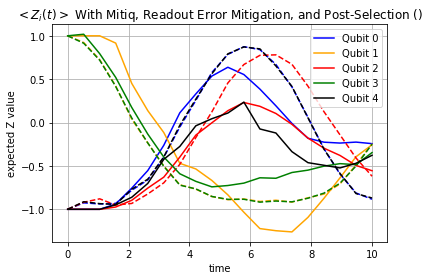

In [55]:
t=np.linspace(0,TT,NN)

fig,ax = plt.subplots()
ax.plot(t, real_device_dict[0], label='Qubit 0', color = 'blue')
ax.plot(t, Sz_sim[:,0], linestyle = 'dashed', color = 'blue')
ax.plot(t, real_device_dict[1], label='Qubit 1', color = 'orange')
ax.plot(t, Sz_sim[:,1], linestyle = 'dashed', color = 'orange')
ax.plot(t, real_device_dict[2], label='Qubit 2', color = 'red')
ax.plot(t, Sz_sim[:,2], linestyle = 'dashed', color = 'red')
ax.plot(t, real_device_dict[3], label='Qubit 3', color = 'green')
ax.plot(t, Sz_sim[:,3], linestyle = 'dashed', color = 'green')
ax.plot(t, real_device_dict[4], label='Qubit 4', color = 'black')
ax.plot(t, Sz_sim[:,4], linestyle = 'dashed', color = 'black')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("$<Z_i(t)>$ With Mitiq, Readout Error Mitigation, and Post-Selection ()")
ax.legend()
ax.grid()

# ED

In [56]:
import scipy.linalg as la

def flip(n,i,L): 
    # Flip the i site spin in n-state with system size L
    ii=2**(L-i-1)
    nn=2**L
    if int(bin(n+nn)[3:][i])==1:
        return binaryToDecimal(int(bin(n-ii)[2:]))
    if int(bin(n+nn)[3:][i])==0:
        return binaryToDecimal(int(bin(n+ii)[2:]))


def binaryToDecimal(binary): 
    # change the binary number into decimal number
    binary1 = binary 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal  

def spin_x(i,L):
    n=2**L
    X=np.zeros((n,n))
    for j in range(n):
        X[j,flip(j,i,L)]=1
    return X

def spin_y(i,L):
    n=2**L
    Y=np.zeros((n,n),dtype=complex)
    for j in range(n):
        Y[j,flip(j,i,L)]=1j*(-1)**(int(bin(j+n)[3:][i]))
    return Y

def spin_z(i,L):
    n=2**L
    Z=np.zeros((n,n))
    #a=2**L-1
    for j in range(n):
        Z[j,j]=2*int(bin(j+n)[2:][::-1][i])-1
    return Z

In [57]:
L=5

Omega=0.2*2
h=2*2 #2*2
V=1*2


H0=0
for i in range(L):
    H0=H0+Omega*spin_x(i,L) # Rabi coupling
    
H1=0
H1=H1+h*spin_z(0,L)/2
H1=H1+h*spin_z(L-1,L)/2
for i in range(L-2):
    H1=H1+h*spin_z(i+1,L) 


V0=0
for i in range(L-1):
    n_f=spin_z((i)%L,L)
    n_b=spin_z((i+1)%L,L)
    V0=V0+V*np.dot(n_f,n_b)


H=H0+H1+V0

In [58]:
M=H
vals, vecs = la.eigh(M)

inds=np.argsort(vals)
e=vals[inds]
v=vecs[:,inds]

In [59]:
Nt=20-1
T=10
dt=T/Nt

A=np.eye(len(e))*e
U=np.dot(v,np.dot(np.exp(-1j*A*dt)*np.eye(len(e)),np.conj(np.transpose(v))))

f = 10

wavefunc=np.zeros((len(e),Nt+1),dtype=complex)
n=np.zeros(len(e),dtype=complex)
n[f]=1
wavefunc[:,0]=n
for i in range(Nt):
    wavefunc[:,i+1]=np.dot(U,wavefunc[:,i])

In [60]:
def Zi_t_p(tf,dt,f,i):
  
  
    Nt=tf/dt
    Nt=int(Nt)

    Zt=spin_z(i,L)
    Zt1=[np.real(np.dot(np.conjugate(wavefunc[:,i]),np.dot(Zt,wavefunc[:,i]))) for i in range(Nt+1)]
    Zt1=np.stack(Zt1,axis=0)
    return Zt1

In [61]:
Zi=np.zeros((L,Nt+1))
for i in range(L):
    Zi[i,:]=np.real(Zi_t_p(T,dt,f,i))

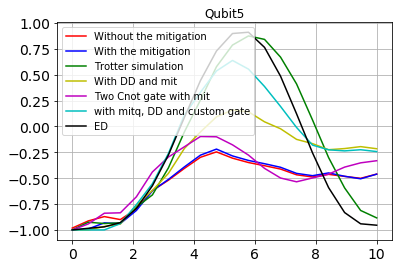

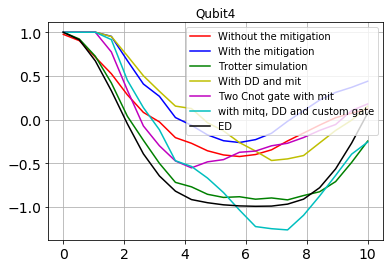

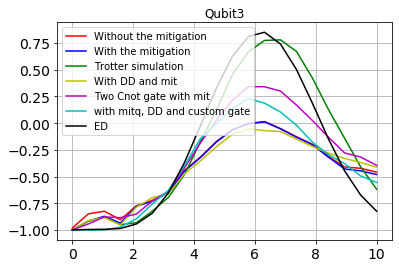

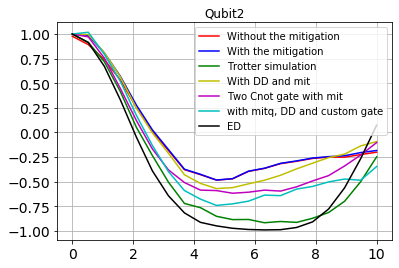

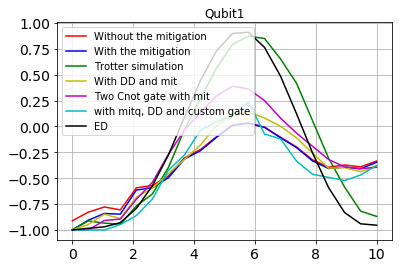

In [62]:
for i in range(5):
    
    t=np.linspace(0,T,NN)
    plt.title("Qubit"+str(5-i))
    plt.plot(t,Sz_nomit[:,i],color='r',label='Without the mitigation')
    plt.plot(t,Sz_mit[:,i],color='b',label='With the mitigation')
    plt.plot(t,Sz_sim[:,i],color='g',label='Trotter simulation')
    plt.plot(t,Sz_mit_DD[:,i],color='y',label='With DD and mit')
    plt.plot(t,Sz_mit_no_custom[:,i],color='m',label='Two Cnot gate with mit')
    plt.plot(t,real_device_dict[i],color='c',label='with mitq, DD and custom gate')
    plt.plot(t,Zi[i,:],color='k',label='ED')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

In [63]:
Omega = 0.2*2

h = 2*2

V = 1*2

T = 10 # Total time

TT=T

#NEED TO CHECK IF THIS IS ALLOWED
delta_t = .5

#CHECK THIS AS WELL
n = int(np.rint(T/delta_t))

Trotter_result_scale2 = Trotter_circuit_5_site_folding_scale2(h,Omega,V,T,n,qubits_list)


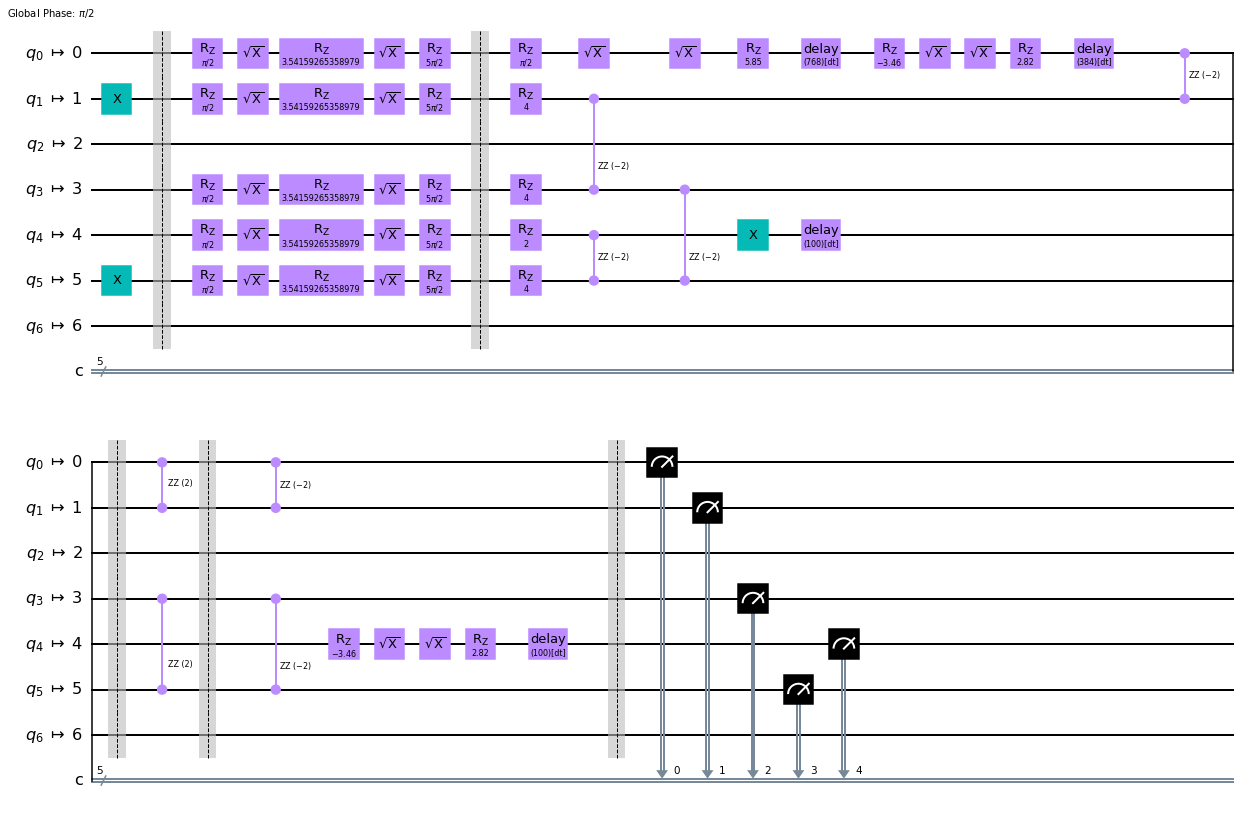

In [64]:
Trotter_result_scale2[1].draw('mpl')

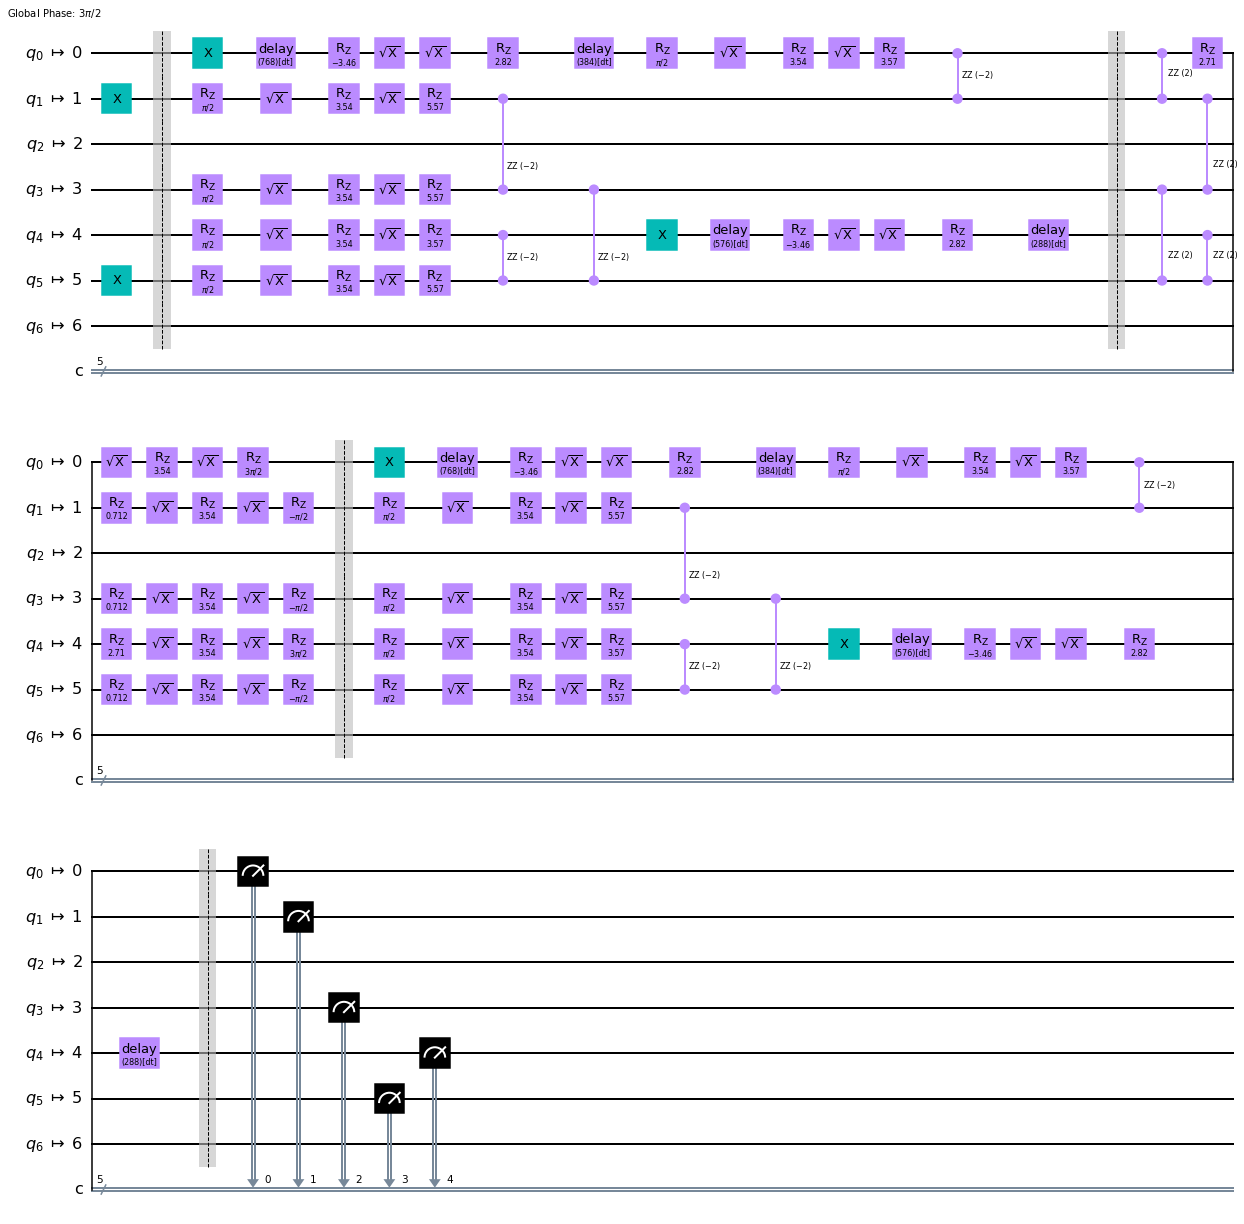

In [65]:
Trotter_result_scale3 = Trotter_circuit_5_site_folding_scale3(h,Omega,V,T,n,qubits_list)

Trotter_result_scale3[1].draw('mpl')

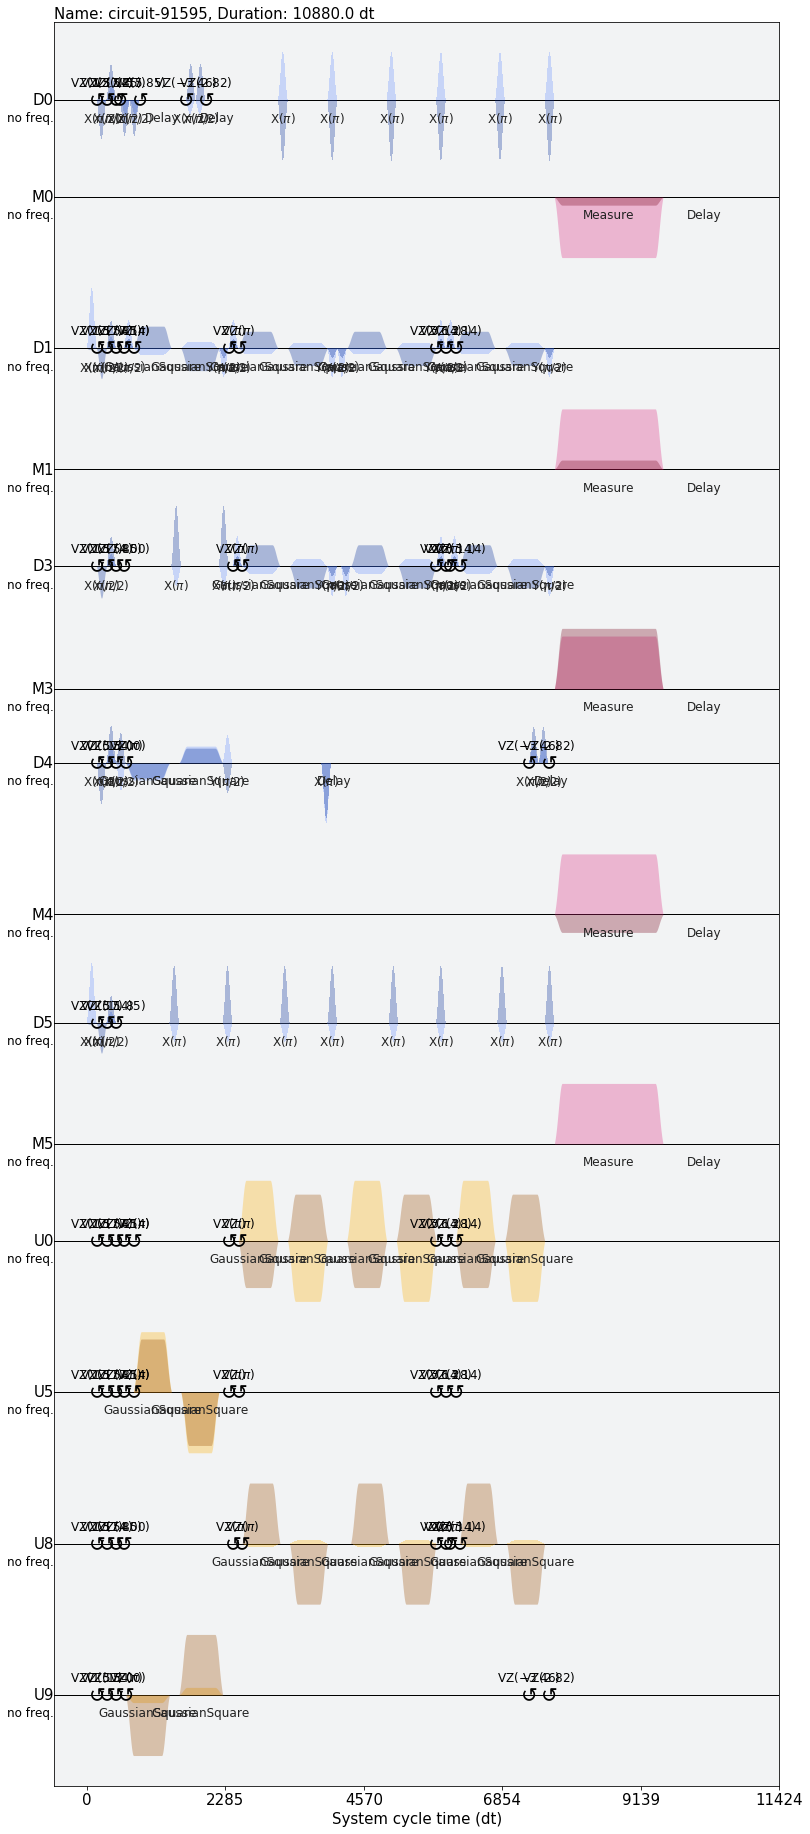

In [66]:
pulse_schedule = schedule(Trotter_result_scale2[1], backend)
pulse_schedule.draw()

In [67]:
def Trotter_circuit_5_site_folding_scale2_1 (h,Omega,V,T,n,qubits_list):

    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(backend_config.n_qubits,5)
        
        ### Initial state setting
        
        Trotter_circuit.x(q1)
        
        Trotter_circuit.x(q3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            
            X_Rabi(Trotter_circuit,Omega,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
            Trotter_circuit.barrier()
            
            X_Rabi(Trotter_circuit,-Omega,dt,qubits_list)
            
            X_Rabi(Trotter_circuit,Omega,dt,qubits_list)
            
            h_Z(Trotter_circuit,h,dt,qubits_list) # Z field 
            
            ZZ(Trotter_circuit,V,dt,qubits_list) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
            ZZ_half(Trotter_circuit,-V,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
            Trotter_circuit.barrier() # Z field 
            
            ZZ_half(Trotter_circuit,V,dt,qubits_list)
            
            # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        #j=0
        
        #for i in qubits_list:
            
        #    Trotter_circuit.measure(i,j)
            
        #    j+=1

        Trotter_circuit.add_calibration('rzz', [q0,q1], Rzz_gate_schedule (q0,q1,-2*V*dt), [-2*V*dt]) 
        
        Trotter_circuit.add_calibration('rzz', [q2,q3], Rzz_gate_schedule (q2,q3,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q1,q2], Rzz_gate_schedule (q1,q2,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q3,q4], Rzz_gate_schedule (q3,q4,-2*V*dt), [-2*V*dt])

        Trotter_circuit.add_calibration('rzz', [q1,q2], Rzz_gate_schedule (q1,q2,2*V*dt), [2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q3,q4], Rzz_gate_schedule (q3,q4,2*V*dt), [2*V*dt])

        Trotter_circuit.add_calibration('rzz', [q0,q1], Rzz_gate_schedule (q0,q1,2*V*dt), [2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q2,q3], Rzz_gate_schedule (q2,q3,2*V*dt), [2*V*dt])

        Trotter_circuit = transpile(Trotter_circuit, backend)
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

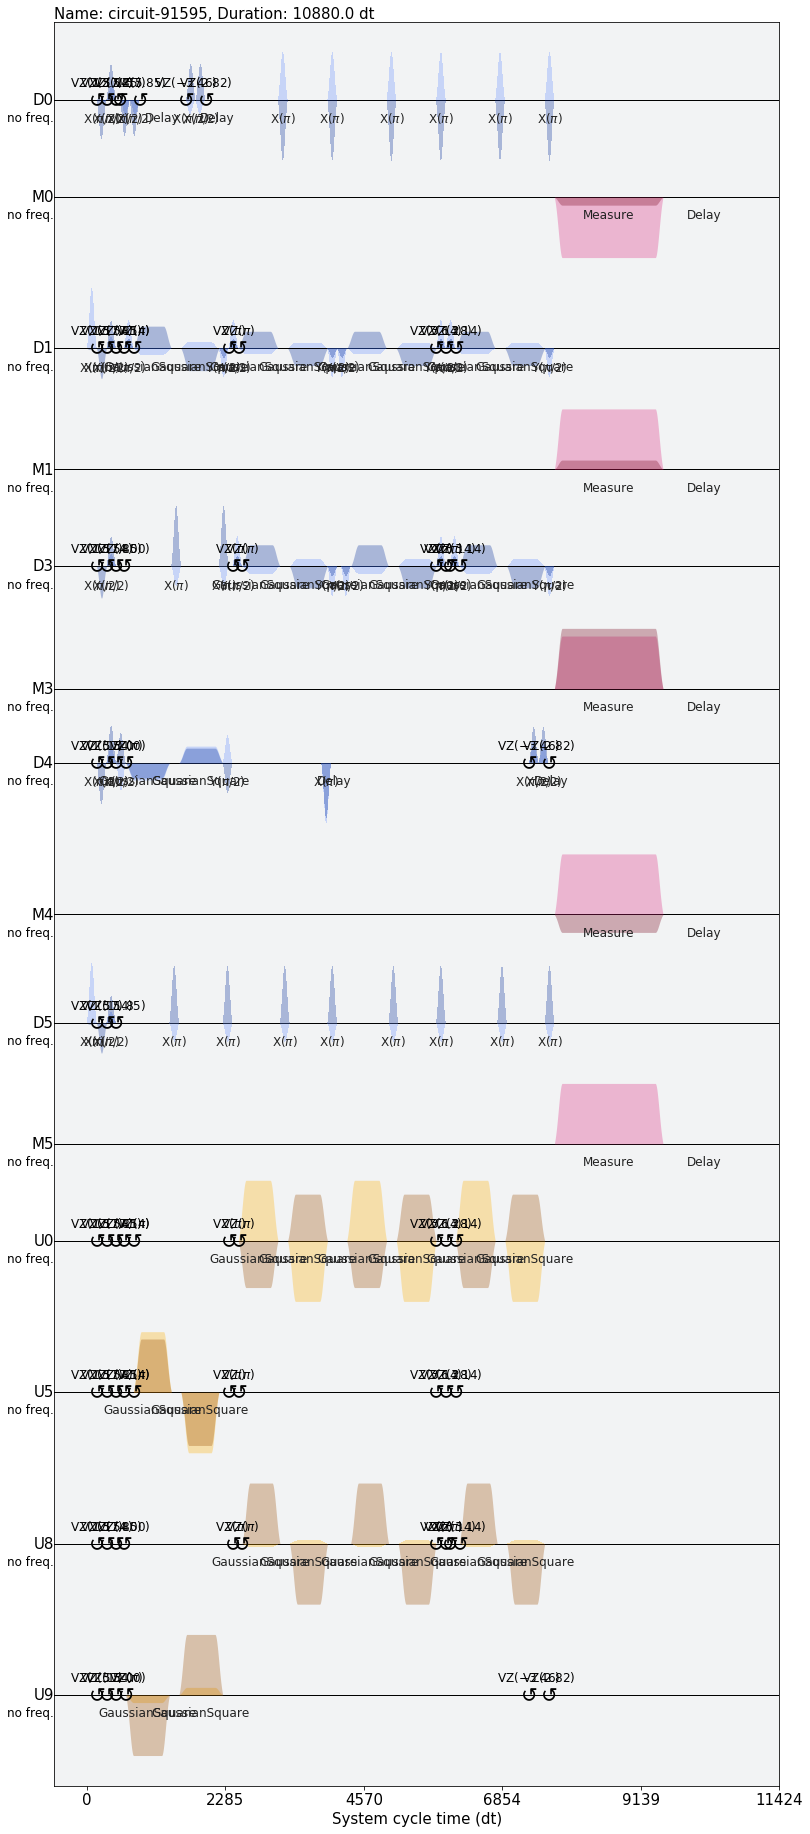

In [68]:
pulse_schedule = schedule(Trotter_result_scale2[1], backend)
pulse_schedule.draw()

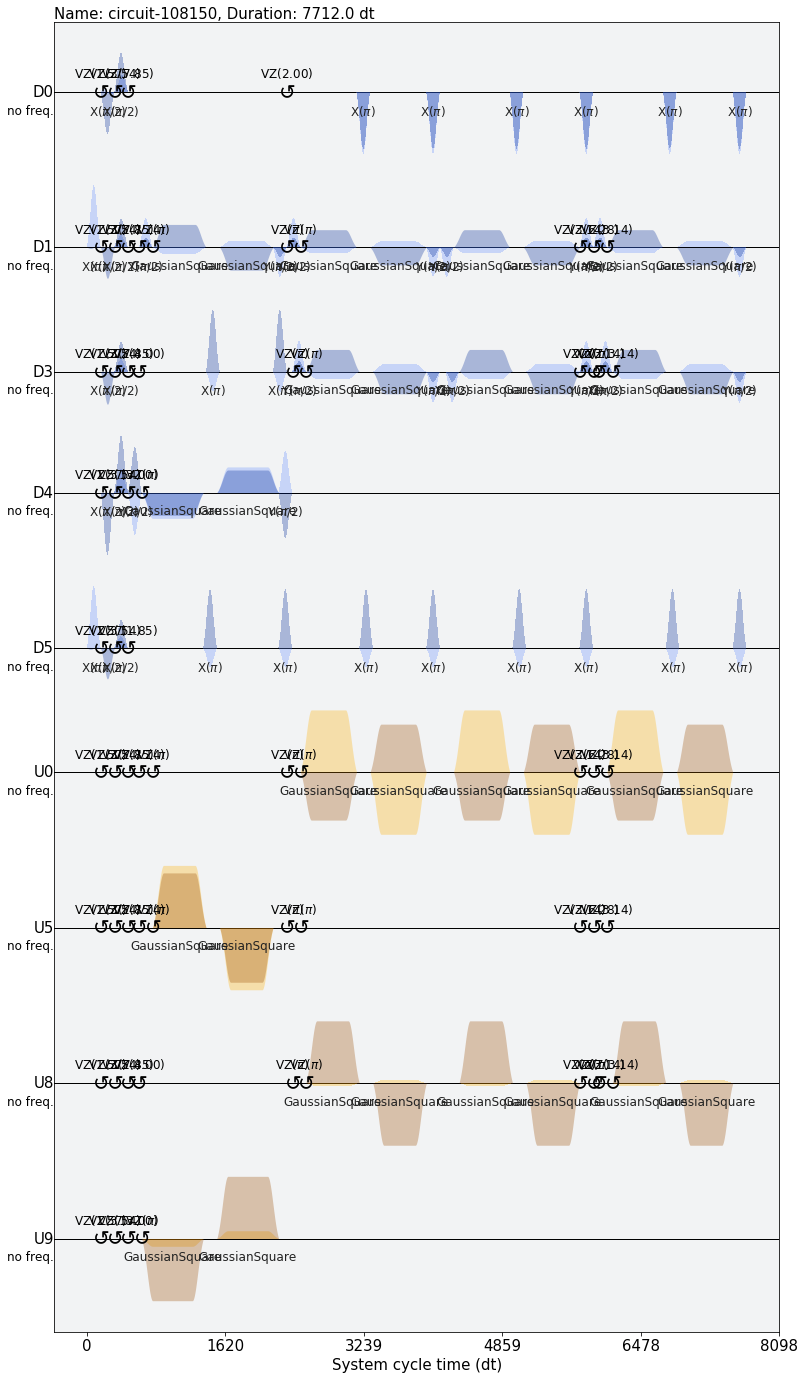

In [69]:
Trotter_result_scale2_1 = Trotter_circuit_5_site_folding_scale2_1(h,Omega,V,T,n,qubits_list)

pulse_schedule = schedule(Trotter_result_scale2_1[1], backend)
pulse_schedule.draw()

In [70]:

#Parameters used for the Trotter cirucit
Omega = 0.2*2

h = 2*2

V = 1*2

T = 10 # Total time

TT=T

#NEED TO CHECK IF THIS IS ALLOWED
delta_t = .5

#CHECK THIS AS WELL
n = int(np.rint(T/delta_t))

Trotter_circuit = Trotter_circuit_5_site_folding_scale2(h,Omega,V,T,n,qubits_list)

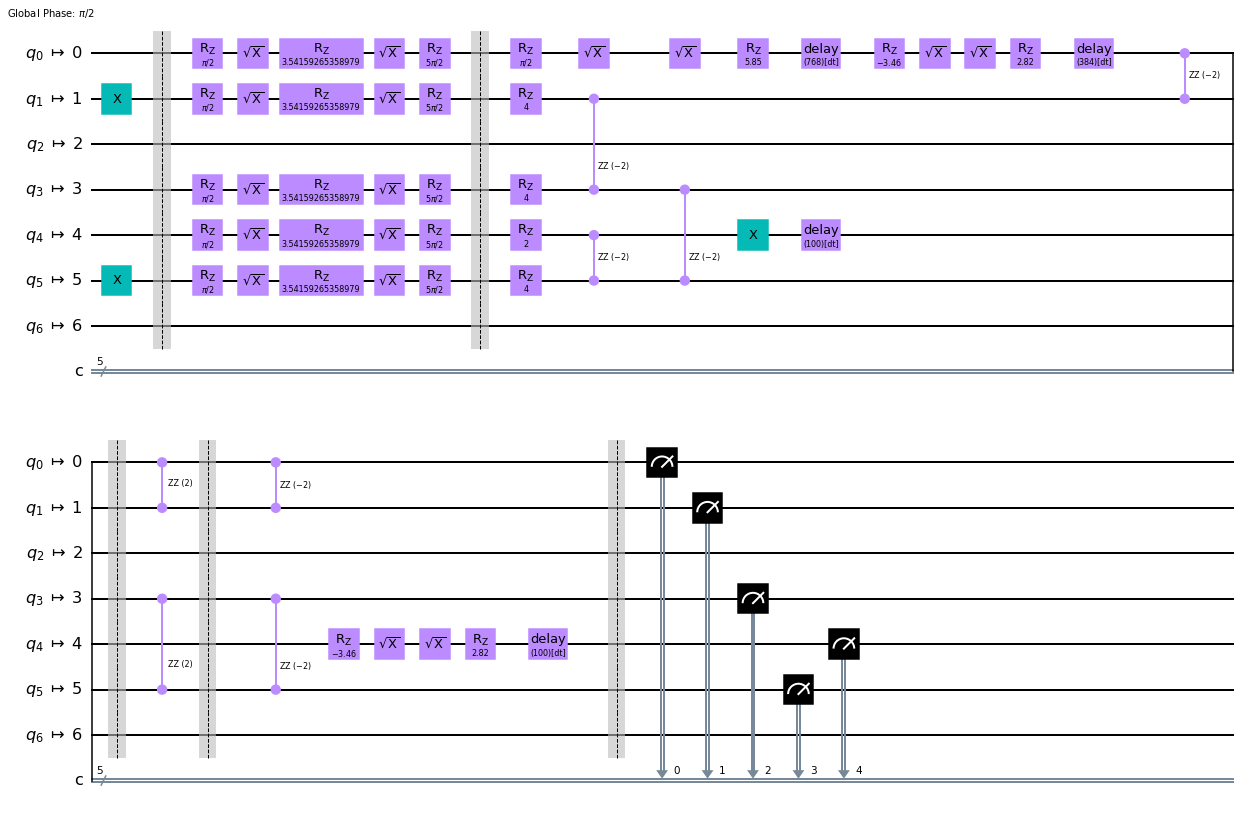

In [71]:
Trotter_circuit[1].draw('mpl')

In [72]:
Trotter_circuit = Trotter_circuit_5_site_folding_scale1(h,Omega,V,T,n,qubits_list)

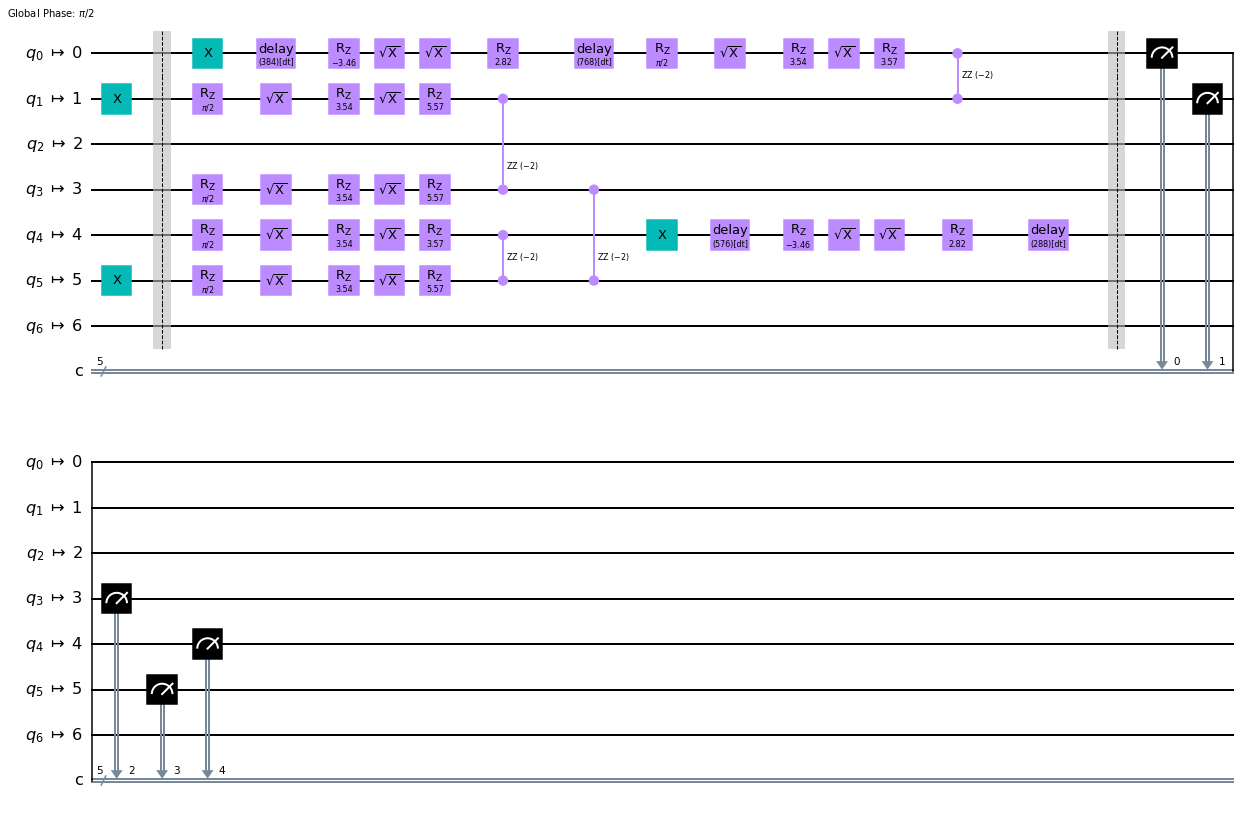

In [73]:
Trotter_circuit[1].draw('mpl')

In [74]:
Trotter_circuit = Trotter_circuit_5_site_folding_scale3(h,Omega,V,T,n,qubits_list)

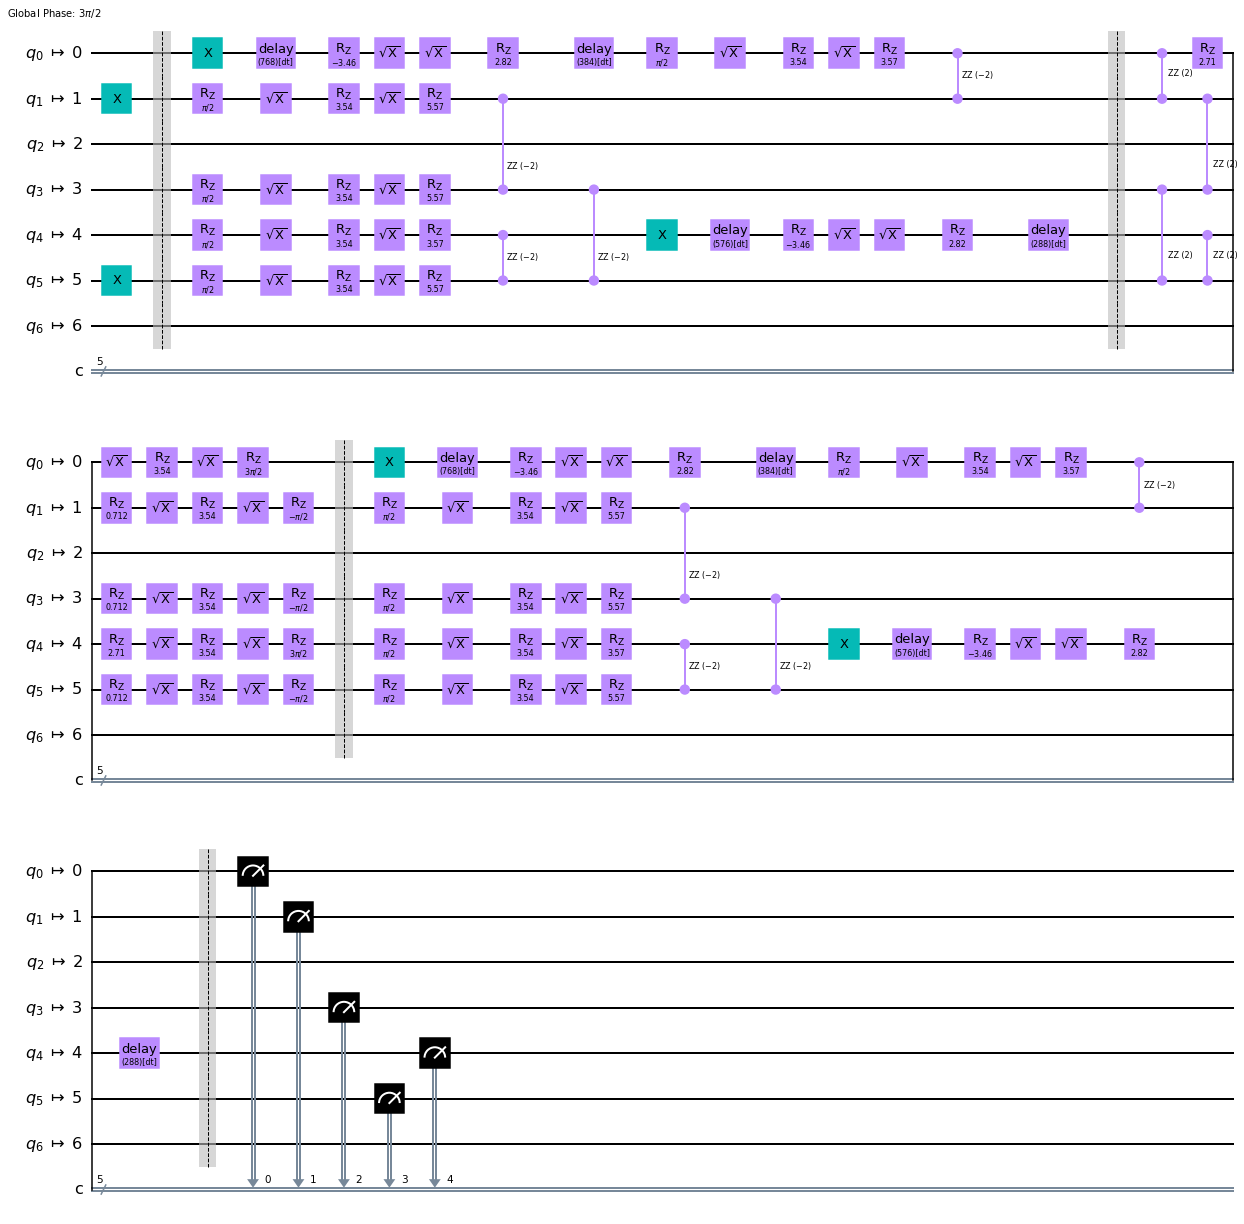

In [75]:
Trotter_circuit[1].draw('mpl')
